# Image Enhancement

## Initialization

In [30]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from matplotlib.colors import NoNorm

In [31]:
# convenience function that estimates the difference between 2 images
def diffscore(img1, img2):
    return np.sum(abs(img1-img2))

# convenience function to draw 1 image - no typing 4 lines anymore
def display(img):
    plt.figure()
    plt.axis("off")
    if len(img.shape) < 3:
        plt.imshow(img,cmap='gray',norm=NoNorm())
        # this ensures plt doesn't treat our grayscale array as a messed-up 3-channel image
    else:
        plt.imshow(img)
    plt.show()

In [16]:
# read original image, converting to RGB because that format is expected by matplotlib
src_raw = cv2.cvtColor(cv2.imread("src.jpg"), cv2.COLOR_BGR2RGB)
src = cv2.resize(src_raw, dsize=None, fx=0.2, fy=0.2, interpolation=cv2.INTER_CUBIC)

## Noise

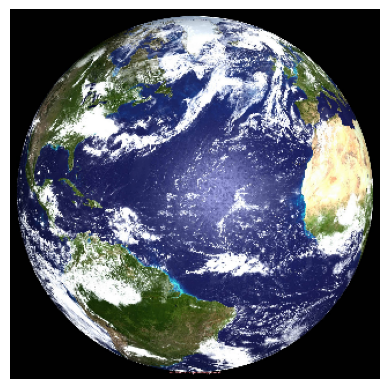

In [32]:
display(src)

What kinds of noise could we get? We have already encountered salt-and-pepper-ish noise

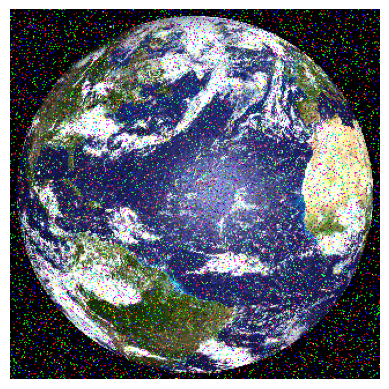

In [33]:
import random
def pepper_salt(img, low=16, high=242):
    out = img.copy()
    random_mat = np.array([[random.randint(0, 255) for j in range(img.shape[1])] for i in range(img.shape[0])])
    pepper_mat = random_mat<low
    pepper_mat = np.stack((pepper_mat,pepper_mat,pepper_mat), axis=2)
    salt_mat = random_mat>high
    salt_mat = np.stack((salt_mat,salt_mat,salt_mat), axis=2)
    
    out = np.where(pepper_mat, 0, out)
    out = np.where(salt_mat, 255, out)
    return out

def upset_data(img, low=16, high=242):
    out = img.copy()
    if len(out.shape) == 2:
        depth = 1
        out = np.expand_dims(out, axis=2)
    else: depth = out.shape[2]
    
    for channel in range(depth):
        random_mat = np.array([[random.randint(0, 255) for j in range(img.shape[1])] for i in range(img.shape[0])])
        pepper_mat = random_mat<low
        salt_mat = random_mat>high
        out[:,:,channel] = np.where(pepper_mat, 0, out[:,:,channel])
        out[:,:,channel] = np.where(salt_mat, 255, out[:,:,channel])
    return out

display(upset_data(src))

And there's also Gaussian noise and its ~siblings

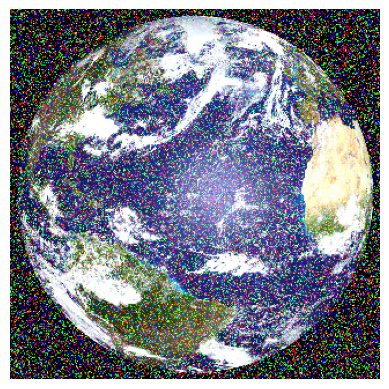

In [34]:
def gauss_noise(img, loc=0, stdev=1):
    gauss = np.random.normal(loc,stdev,img.shape)
    gauss = gauss.reshape(img.shape[0],img.shape[1],img.shape[2]).astype('uint8')
    return cv2.add(img, gauss)

def rayleigh_noise(img, scale=1):
    rayleigh = np.random.rayleigh(scale,img.shape)
    rayleigh = rayleigh.reshape(img.shape[0],img.shape[1],img.shape[2]).astype('uint8')
    return cv2.add(img, rayleigh)

def gamma_noise(img, shape=1, scale=1):
    gamma = np.random.gamma(shape, scale ,img.shape)
    gamma = gamma.reshape(img.shape[0],img.shape[1],img.shape[2]).astype('uint8')
    return cv2.add(img, gamma)

def uniform_noise(img, low=0, high=255):
    uniform = np.random.uniform(low, high ,img.shape)
    uniform = uniform.reshape(img.shape[0],img.shape[1],img.shape[2]).astype('uint8')
    return cv2.add(img, uniform)
    

display(gauss_noise(src))

## Filtering

We already encountered the median filter, and observed how it can scrub salt-and-pepper out quite well

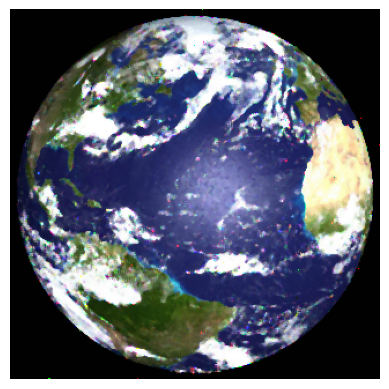

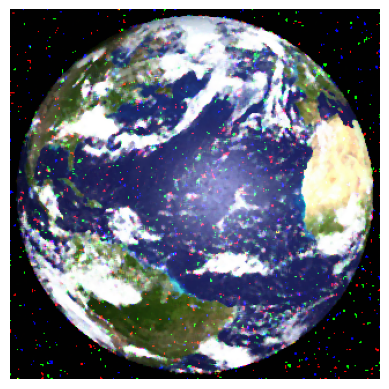

In [35]:
display(cv2.medianBlur(upset_data(src), 3))
display(cv2.medianBlur(gauss_noise(src), 3))

But it clearly doesn't deal quite as well with more uniformly noisy images. We have to expand our toolbox.

#### Standartization (5 points)

In [36]:
def apply_filter(img, ffunc, sx=3, sy=3, **kwargs):
    out = img.copy()
    height, width, channels = img.shape
    cx = sx//2
    cy = sy//2
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            window = img[max(0,x-cx):min(x+cx,height),max(0,y-cy):min(y+cy,width),:]
            out[x][y] = ffunc(window, **kwargs)
    return out

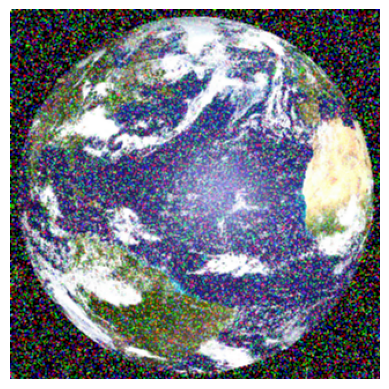

In [29]:
def skewed_identity(region):
    height, width, channels = region.shape
    return region[int(height/2),int(width/2),:]

display(apply_filter(gauss_noise(src), contra_mean, q=0))

In [28]:
def _mean(region):
    out = None
    
    return out

#### Arithmetic Mean Filter (10 points)

In [27]:
def arith_mean(region):
    height, width, channels = region.shape
    out = [0]*channels
    for c in range (channels):
        out[c] = np.mean(region[:,:,c])
    return out

#### Geometric Mean Filter (15 points)

In [26]:
def geom_mean(region):
    height, width, channels = region.shape
    out = [0]*channels
    for c in range (channels):
        out[c] = np.exp(np.log(region[:,:,c]).mean())
    return out

#### (Contra)Harmonic Mean Filter (10 points)

In [25]:
def contra_mean(region, q):
    out = None
    height, width, channels = region.shape
    out = [0]*channels
    for c in range (channels):
        layer = region[:,:,c]
        out[c] = np.sum(np.float_power(layer,q+1)) / np.sum(np.float_power(layer,q))
    return out

Apart from all the mean variations, we get other statistics filters:

#### Min/ Max Filters (5 points)

In [37]:
def max_filter(region):
    out = None
    height, width, channels = region.shape
    out = [0]*channels
    for c in range (channels):
        out[c] = np.max(region[:,:,c])
    return out

def min_filter(region):
    out = None
    height, width, channels = region.shape
    out = [0]*channels
    for c in range (channels):
        out[c] = np.min(region[:,:,c])
    return out

#### Midpoint Filter (5 points)

In [38]:
def mid_filter(region):
    out = None
    outmax = np.array(max_filter(region))/2
    outmin = np.array(min_filter(region))/2
    out = (outmax+outmin) # (outmax+outmin)/2
    return out

Lastly, we also have sharpening via edge detection we have previously discussed:

#### Laplacian Sharpening (5 points)
By out definition, the "sharpened" function is one with the second-order derivative added

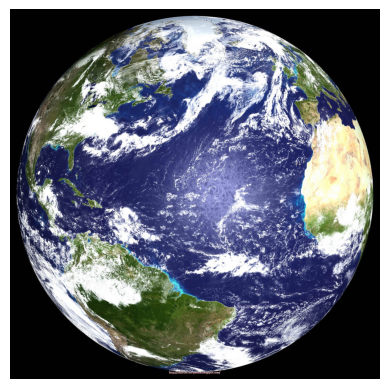

In [39]:
laplace_kernel = np.array([[0,-1,0],
                           [-1,4,-1],
                           [0,-1,0]])
sobel_kernel = np.array([[1,2,1],
                         [0,0,0],
                         [1,2,1]])
def sharpen(img):
    out = img.copy() 
    edges = cv2.filter2D(src=img, ddepth=-1,kernel=laplace_kernel)
    out = cv2.add(out, edges)
    return out
display(sharpen(src_raw))

# Homework

You will have to take a picture to do this homework; something noisy, ideally just a picture taken in a dark place so the camera can't quite capture everything correctly.

#### Statistics (25 points)

Show the noise distribution histogram and calculate mean, var, std, a and b (all constants in the distribution formula) for the picture you've taken.

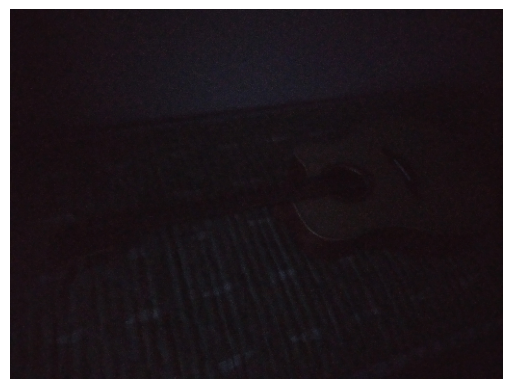

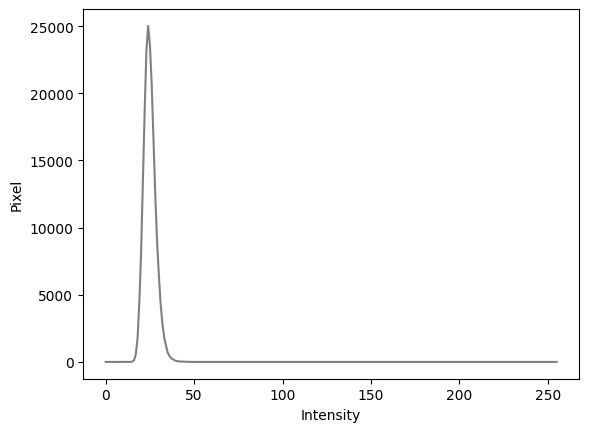

Mean:  24.973607381184895 
Var:  3.4372736436340805 
Std:  1.8539885769966546 
a:  [181.44643991] 
b:  [1.]


In [40]:
dark_raw = cv2.cvtColor(cv2.imread("darkphoto2.jpg"), cv2.COLOR_BGR2RGB)
dark = cv2.resize(dark_raw, dsize=None, fx=0.2, fy=0.2, interpolation=cv2.INTER_CUBIC)


display(dark)

#noise distr hist
hist = cv2.calcHist([dark], [0], None, [256], [0, 256])
plt.plot(hist, color='gray')
plt.xlabel('Intensity')
plt.ylabel('Pixel')
plt.show()

mean, var = cv2.meanStdDev(dark)
std = np.sqrt(var)

a = (mean[0]/std[0])**2
b = var[0]/std[0]**2

print("Mean: ", mean[0][0], "\nVar: ", var[0][0], "\nStd: ", std[0][0], "\na: ", a, "\nb: ", b)


#### Enhancement (20 points)

Enhance the picture you've taken as best you can using methods from this practical (methods from previous practicals also welcome).

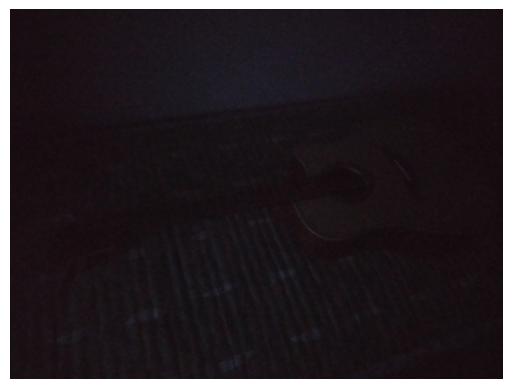

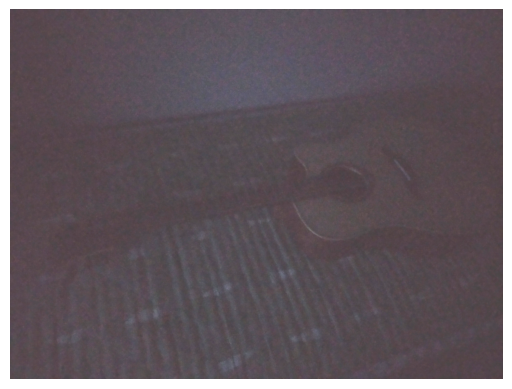

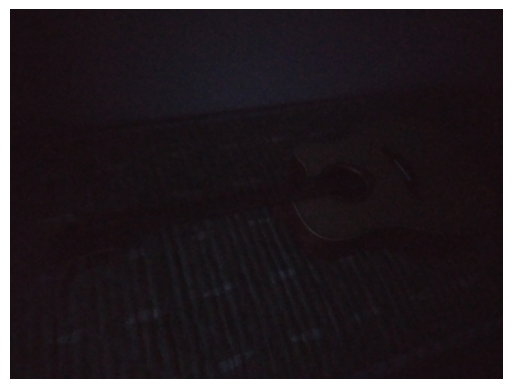

In [51]:
# dark_raw = cv2.cvtColor(cv2.imread("darkphoto2.jpg"), cv2.COLOR_BGR2RGB)
# dark = cv2.resize(dark_raw, dsize=None, fx=0.2, fy=0.2, interpolation=cv2.INTER_CUBIC)

# display(dark)

# dark_enhanced = cv2.equalizeHist(cv2.cvtColor(dark, cv2.COLOR_BGR2GRAY))
# display(dark_enhanced)


dark_raw = cv2.imread("darkphoto2.jpg")
dark = cv2.cvtColor(dark_raw, cv2.COLOR_BGR2RGB)

display(dark)

a = 1.5 
b = 50 
adjusted = cv2.convertScaleAbs(dark, alpha=a, beta=b)

enhanced = cv2.medianBlur(adjusted, 3)
enhanced = apply_filter(enhanced, skewed_identity)

display(enhanced)

enhanced_dark = cv2.medianBlur(dark, 3)
enhanced_dark = apply_filter(enhanced_dark, skewed_identity)

display(enhanced_dark)
